# topic-model-v2
SanjayKAroraPhD@gmail.com <br>
November 2021

## Description
This notebook trains topic models on firm pages, segmenting those pages by firm groups as appropriate. v3 limits segments to small nano, renewable energy, and sybio firms and transitions to lda mallet (besides for perplexity scores, which don't seem too helpful anyways)

## TODO:

In [1]:
%matplotlib inline
import os
import os.path
import random
import re
import gensim
import string
import math
from gensim import corpora
from gensim import utils
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from collections import defaultdict
import copy as cp
from bs4 import BeautifulSoup
from functools import reduce 
import operator
import matplotlib.pyplot as plt
import pprint
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pyLDAvis
import pyLDAvis.gensim

In [2]:
import warnings;
warnings.simplefilter('ignore')

In [3]:
# set this home data dir
BASE_DATA_DIR = "/Users/Sanjay.K.Arora/dev/EAGER/data/"
# for groups of words not in sentence format, group chunks of content; this is measured in number of characters 
MALLET_PATH = '/Users/Sanjay.K.Arora/dev/EAGER/libraries/mallet-2.0.8/bin/mallet' # update this path
PHRASE_LENGTH = 50
CLND_MIN_PARA_LEN = 3
RAW_MIN_PARA_LEN = 6

## Load website data from file
Look for text files prepared from MongoDB (the Scrapy scraper)

In [4]:
#import demo text files
in_path = BASE_DATA_DIR + 'orgs/parsed_page_output/' # where in files are stored
files = os.listdir(in_path)
files = [item for item in files if item.endswith('.txt')]

In [5]:
#generate pooled text and list of processed documents for topic model
combined_text = []
documents_dict = {}
for i in range(len(files)):
    with open(in_path + files[i], 'r') as my_file:
        text = my_file.readlines() # this is each separate paragraph including headers etc.
        for k in ["\n", "\t", " "]: # remove the end of sentence tags
            text = [item.strip(k) for item in text]
        text = list(filter(lambda x : not x in [' ', '', '\t'],text)) #remove the paragraphs that are just blank space
        documents_dict[files[i]] = text #make a list of lists
    if i >= 99: # TEMP: limit to n docs
        break 

In [6]:
pp = pprint.PrettyPrinter()
## pp.pprint(documents_dict) 

## Data Prep

### Prepare text for topic modelling

In [7]:
# run once if needed and download the popular corpora (e.g., stopwords) 
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Sanjay.K.Arora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Sanjay.K.Arora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# pattern regex to remove unwanted words that show up in topic models
p = re.compile(r"(\(\)|''|``|\"|null|ul|li|ol|^\.|^:|^/|\\|--|cooki|'s|corpor|busi|inc\.|ltd|co\.|compan|keyboard|product|technolog)", flags=re.IGNORECASE)

def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += item.encode('ascii','ignore').decode('utf-8') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

#tokenize text for topic modelling
def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = list(filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)]))
    return words_stemmed

def clean_text (text):
    clnd_text = list(filter(lambda x : not p.match(x), text))
    return clnd_text

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text] 
    all_content_stem_token = list(map(stem_tokenizer, all_content))
    all_content_clnd = list(map(clean_text, all_content_stem_token))
    # TODO: remove dup words within para 
    all_content_clnd = [set(c) for c in all_content_clnd ]
    all_content_trimmed = [c for c in all_content_clnd if len(c) >= CLND_MIN_PARA_LEN ]

    all_content_no_dups = []
    seen = {}
    for trimmed in all_content_trimmed:
        trimmed_joined = '|'.join(trimmed)
        if trimmed_joined not in seen: 
            all_content_no_dups.append(trimmed)
            seen[trimmed_joined] = 1
        
    return all_content_no_dups

In [9]:
# test regex
mock_data = {}
mock_data['fake firm'] = ['this is the first sentence in my paragraph, and it keeps on going!', 
                          'this is a technology corporation or company or business or firm that produces products and widgets using tech, research and productization', 
                          'i am a null sentence with ul li () 4 42 `` -- this has some keyboard-left text and a quotation computer #test "safety first"',
                          'a sentence with less than MIN_PARA_LEN',
                          'i am a null sentence with ul li () 4 42 `` -- this has some keyboard-left text and a quotation computer #test "safety first"',
                          'a sentence with less than MIN_PARA_LEN']

return_for_model (mock_data['fake firm'] )

[{'first', 'go', 'keep', 'paragraph', 'sentenc'},
 {'firm', 'produc', 'research', 'tech', 'use', 'widget'},
 {'4', '42', 'comput', 'first', 'quotat', 'safeti', 'sentenc', 'test', 'text'},
 {'less', 'min_para_len', 'sentenc'}]

In [10]:
def process_doc_list(dict_of_docs):
    '''
    input: lists of documents (which are individually lists of paragraphs)
    output: returns a test/train split of paragraphs and stemmed documents
    '''
    combined_text = []
    documents = []
    dict_of_processed_docs = {}
    print ("Working on " + str(len(dict_of_docs.keys())) + " firm documents")
    c = 1
    for key in dict_of_docs:
        
        document = dict_of_docs[key]
        # print ("Working on doc " + key)
        
        # loop over text and add title elements to the paragraph they describe
        joined = []
        buf = ''
        for i in range(len(document)): # figure out a way to chunk groups of content
            if re.search (r'cookie|privacy|terms|GDPR', document[i], re.IGNORECASE):
                continue
            if len(document[i]) <= 12 or len(document[i].split()) < RAW_MIN_PARA_LEN : # maybe a menu or simple pagragraph heading? 
                continue
            if re.search(r'(\.|;|\!)', document[i]): # found what appears to be a sentence
                if buf:
                    joined.append(buf.strip())
                    buf = ''
                joined.append(document[i].strip())
            elif len(buf) > PHRASE_LENGTH: # the rest of this code processes free-standing text 
                joined.append(buf.strip())
                buf = document[i]
            else: 
                buf = buf + ' ' + document[i]
        if buf:
            joined.append(buf.rstrip())
        
        combined_text += joined # make a big list
        documents.append(joined) # make a list of lists
        
        dict_of_processed_docs[key] = return_for_model(joined)
    
    combined = return_for_model(combined_text)

    return dict_of_processed_docs

### Process Documents for Topic Modelling

In [11]:
all_docs_dict = process_doc_list(mock_data)
pp.pprint(all_docs_dict)

Working on 1 firm documents
{'fake firm': [{'go', 'sentenc', 'keep', 'paragraph', 'first'},
               {'use', 'firm', 'widget', 'produc', 'research', 'tech'},
               {'4',
                '42',
                'comput',
                'first',
                'quotat',
                'safeti',
                'sentenc',
                'test',
                'text'},
               {'4',
                '42',
                'comput',
                'first',
                'less',
                'min_para_len',
                'quotat',
                'safeti',
                'sentenc',
                'test',
                'text'},
               {'less', 'sentenc', 'min_para_len'}]}


In [12]:
# use the preceeding fuction to process the text data
all_docs_dict = process_doc_list(documents_dict)
pp.pprint(all_docs_dict)

Working on 100 firm documents
{'ARBOR THERAPEUTICS.txt': [{'prescrib', 'inform', 'includ', 'warn', 'box'},
                            {'bring',
                             'develop',
                             'experi',
                             'fulli',
                             'healthcar',
                             'led',
                             'mani',
                             'patient',
                             'peopl',
                             'pharmaceut',
                             'practition',
                             'process',
                             'skill',
                             'team',
                             'understand',
                             'valu',
                             'veteran'},
                            {'alreadi',
                             'approv',
                             'chemic',
                             'clinic',
                             'collabor',
                         

                         'whi',
                         'work'},
                        {'achiev',
                         'employe',
                         'ensur',
                         'goal',
                         'health',
                         'necessari',
                         'person',
                         'resourc',
                         'tool',
                         'well'},
                        {'activ',
                         'associ',
                         'care',
                         'community-bas',
                         'engag',
                         'eye',
                         'improv',
                         'level',
                         'local',
                         'project',
                         'servic',
                         'volunt',
                         'worldwid'},
                        {'abl',
                         'alcon',
                         'background',
                       

                                  'monitor',
                                  'occur',
                                  'pain',
                                  'patient',
                                  're-appear',
                                  'reaction',
                                  'restart',
                                  'short',
                                  'sign',
                                  'size',
                                  'sudden',
                                  'symptom',
                                  'thrombosi',
                                  'treatment',
                                  'vascular',
                                  'week'},
                                 {'alter',
                                  'anticoagul',
                                  'dure',
                                  'effect',
                                  'establish',
                                  'manag',
                     

                                  'diseas',
                                  'effect',
                                  'evalu',
                                  'exclus',
                                  'focus',
                                  'lack',
                                  'opportun',
                                  'option',
                                  'patient',
                                  'rare',
                                  'team',
                                  'therapi',
                                  'treatment'},
                                 {'also',
                                  'complement',
                                  'effort',
                                  'intern',
                                  'maxim',
                                  'opportun',
                                  'partnership',
                                  'potenti',
                                  'research',
                     

                                  'prior',
                                  'repres',
                                  'rose',
                                  'sale',
                                  'senior',
                                  'serv',
                                  'subsidiari',
                                  'vice',
                                  'zeneca'},
                                 {'america',
                                  'astrazeneca',
                                  'board',
                                  'brennan',
                                  'current',
                                  'director',
                                  'elsevi',
                                  'incorpor',
                                  'innocol',
                                  'insm',
                                  'manufactur',
                                  'mr.',
                                  'pharmaceut',
                     

                  'form',
                  'hereditari',
                  'includ',
                  'longer',
                  'mani',
                  'million',
                  'occur',
                  'peopl',
                  'popul',
                  'prolong',
                  'result',
                  'solid',
                  'take',
                  'von',
                  'vwd',
                  'vwf',
                  'willebrand',
                  'world'},
                 {'2018',
                  '23',
                  'access',
                  'center',
                  'control',
                  'diseas',
                  'https',
                  'januari',
                  'prevent',
                  'websit'},
                 {'learn',
                  'part',
                  'pharmaceut',
                  'plc',
                  'select',
                  'shire',
                  'takeda'},
                 {'inform', 'selec

                 {'2019',
                  'diseas',
                  'fund',
                  'polici',
                  'principl',
                  'rare',
                  'reserv',
                  'right',
                  'shire'},
                 {'advocaci',
                  'effort',
                  'focus',
                  'follow',
                  'hand',
                  'histori',
                  'imper',
                  'long',
                  'organ',
                  'patient',
                  'shire',
                  'support',
                  'work'},
                 {'bring',
                  'differ',
                  'make',
                  'organ',
                  'patient',
                  'shire',
                  'valu'},
                 {'advocaci',
                  'foster',
                  'organ',
                  'patient',
                  'relationship',
                  'sustain'},
                 {'champ

                      'motor',
                      'show',
                      'worldwid'},
                     {'abov',
                      'across',
                      'brand',
                      'cool',
                      'dynam',
                      'energet',
                      'europ',
                      'european',
                      'festiv',
                      'fireston',
                      'heart',
                      'key',
                      'market',
                      'music',
                      'presenc',
                      'reassert',
                      'sponsor',
                      'young'},
                     {'1-1',
                      '104-8340',
                      '3-chome',
                      'chuo-ku',
                      'japan',
                      'kyobashi',
                      'tokyo'},
                     {'2017', '31', '126,354', 'decemb', 'million', '13,706'},
                     {'142

                      'fruitless',
                      'gold',
                      'hord',
                      'kind',
                      'memori',
                      'oil',
                      'prospector',
                      'rush',
                      'seek',
                      'spur'},
                     {'1876',
                      '4',
                      'aim',
                      'alex',
                      'california',
                      'canyon',
                      'demetrius',
                      'despit',
                      'driller',
                      'frederick',
                      'mentri',
                      'mountain',
                      'mud',
                      'oil',
                      'petroleum',
                      'pico',
                      'pioneer',
                      'portion',
                      'predecessor',
                      'rattlesnak',
                      'remot',
         

                      'sumatra',
                      'third-largest',
                      'unit',
                      'use',
                      'vacat'},
                     {'1',
                      '17-year',
                      '1941',
                      '1949',
                      '1950s',
                      '1952',
                      '1969',
                      'addit',
                      'barrel',
                      'billion',
                      'caltex',
                      'develop',
                      'discov',
                      'dure',
                      'duri',
                      'earli',
                      'field',
                      'final',
                      'gain',
                      'giant',
                      'late',
                      'major',
                      'mina',
                      'oil',
                      'pacif',
                      'period',
                      'realiz',
    

                      'set',
                      'sever',
                      'signific',
                      'start-up',
                      'tahiti',
                      'tengiz',
                      'trend',
                      'two',
                      'usan',
                      'volum',
                      'water'},
                     {'2016',
                      'achiev',
                      'ad',
                      'advanc',
                      'april',
                      'australia',
                      'avail',
                      'basin',
                      'capit',
                      'carnarvon',
                      'central',
                      'chevron',
                      'co',
                      'come',
                      'commerci',
                      'construct',
                      'continu',
                      'contribut',
                      'creat',
                      'custom',
               

                      '94583',
                      'addit',
                      'also',
                      'ani',
                      'bolling',
                      'c/o',
                      'canyon',
                      'communic',
                      'compil',
                      'concern',
                      'coordin',
                      'director',
                      'forward',
                      'independ',
                      'interest',
                      'lead',
                      'lengthi',
                      'mail',
                      'may',
                      'offic',
                      'parti',
                      'question',
                      'ramon',
                      'repetit',
                      'request',
                      'road',
                      'san',
                      'secretari',
                      'stockhold',
                      'summar',
                      'wish'},
           

                      'could',
                      'effort',
                      'ensur',
                      'environment',
                      'fledgl',
                      'hawk',
                      'learn',
                      'matur',
                      'near',
                      'nest',
                      'practic',
                      'project',
                      'protect',
                      'red-tail',
                      'remedi',
                      'site',
                      'speci',
                      'two',
                      'undisturb'},
                     {'celebr',
                      'day',
                      'intern',
                      'read',
                      'relat',
                      'stori',
                      'topic',
                      'women'},
                     {'women', 'intern', 'topic', 'day', 'celebr', 'relat'},
                     {'becom',
                      'celebr',
      

                      'contractor',
                      'cover',
                      'depend',
                      'emphas',
                      'environ',
                      'environment',
                      'extern',
                      'health',
                      'human',
                      'improv',
                      'increas',
                      'intern',
                      'issu',
                      'labor',
                      'locat',
                      'major',
                      'manag',
                      'may',
                      'one',
                      'part',
                      'perform',
                      'period',
                      'potenti',
                      'process',
                      'resourc',
                      'right',
                      'risk',
                      'safeti',
                      'select',
                      'standard',
                      'strategi',
        

                     {'copi',
                      'grievanc',
                      'non-retali',
                      'print',
                      'report',
                      'request',
                      'system'}],
 'Cisco Technology.txt': [{'2019',
                           'barcelona',
                           'front',
                           'get',
                           'row',
                           'seat',
                           'stream'},
                          {'everywher', 'center', 'go', 'goe', 'data'},
                          {'app',
                           'center',
                           'control',
                           'data',
                           'everi',
                           'locat',
                           'need',
                           'power',
                           'user'},
                          {'across',
                           'activ',
                           'announc',
            

                           'creat',
                           'ecosystem',
                           'focus',
                           'matter',
                           'partner',
                           'power-up',
                           'strength',
                           'unparallel'},
                          {'amaz',
                           'becom',
                           'bigger',
                           'captur',
                           'condit',
                           'faster',
                           'growth',
                           'opportun',
                           'practic',
                           'skill',
                           'stronger'},
                          {'australia',
                           'barrier',
                           'develop',
                           'first',
                           'great',
                           'help',
                           'itron',
                         

                           'support',
                           'togeth',
                           'valu',
                           'win'},
                          {'see', 'world', 'chang', 'custom'},
                          {'approach',
                           'call',
                           'contact',
                           'get',
                           'montana',
                           'network',
                           'presal',
                           'research',
                           'secur',
                           'state',
                           'take',
                           'univers'},
                          {'access',
                           'architectur',
                           'boundari',
                           'collabor',
                           'commit',
                           'digit',
                           'discoveri',
                           'dna',
                           'engag',
        

                         'year'},
                        {'13th',
                         '1st',
                         '2005',
                         '2007',
                         '65',
                         'abov',
                         'activ',
                         'also',
                         'america',
                         'appoint',
                         'associ',
                         'assur',
                         'benchmark',
                         'big',
                         'centr',
                         'clincial',
                         'clinic',
                         'cmr',
                         'complianc',
                         'cycl',
                         'deliveri',
                         'develop',
                         'devlop',
                         'direct',
                         'director',
                         'enabl',
                         'establish',
                         'europ'

                         {'2007',
                          '2017',
                          'acceler',
                          'act',
                          'advisor',
                          'birmingham',
                          'cap',
                          'capit',
                          'chief',
                          'classmat',
                          'club',
                          'consid',
                          'consider',
                          'dbm',
                          'deal',
                          'dr.',
                          'entrepreneuri',
                          'financi',
                          'greer',
                          'lawrenc',
                          'legal',
                          'manag',
                          'offic',
                          'partner',
                          'program',
                          'schwiebert',
                          'special',
                          's

               'proceed',
               'progress',
               'provid',
               'scope',
               'servic',
               'spicer',
               'supplier',
               'throughout',
               'uncertain',
               'uniqu',
               'way',
               'world'},
              {'18-wheel',
               'build',
               'car',
               'circuit',
               'drive',
               'earth-mov',
               'everi',
               'giant',
               'greatest',
               'help',
               'histori',
               'ii-era',
               'incorpor',
               'jeep',
               'london',
               'machin',
               'model',
               'nascar',
               'race',
               'rig',
               'strength',
               'taxicab',
               'vehicl',
               'war',
               'world'},
              {'2016',
               '23',
               'advanc',
     

                   'reduc',
                   'reliabl',
                   'resist',
                   'safeti',
                   'signal',
                   'site',
                   'smallest',
                   'superior',
                   'synchron',
                   'system',
                   'telecom',
                   'tower',
                   'visibl',
                   'visit',
                   'vital',
                   'weather',
                   'wide'},
                  {'5',
                   'acquisit',
                   'cost-effect',
                   'effici',
                   'energi',
                   'fast',
                   'gsa-certifi',
                   'high-perform',
                   'industri',
                   'infrastructur',
                   'need',
                   'one-stop',
                   'prefer',
                   'price',
                   'process',
                   'procur',
                   'p

                               'use'},
                              {'compressor',
                               'high',
                               'medium',
                               'reciproc',
                               'speed'},
                              {'act',
                               'employe',
                               'ethic',
                               'exercis',
                               'honest',
                               'integr',
                               'judgment',
                               'respons',
                               'sound',
                               'time'},
                              {'adher',
                               'alway',
                               'applic',
                               'compli',
                               'law',
                               'mean',
                               'principl'},
                              {'actual',
                   

                  'underpin'},
                 {'women', 'everi', 'approach', 'day', 'role', 'world', 'men'},
                 {'open', 'sustain', 'pragmat', 'govern'},
                 {'along',
                  'chain',
                  'constant',
                  'improv',
                  'integr',
                  'sector',
                  'seek',
                  'valu',
                  'various'},
                 {'commit',
                  'digitalis',
                  'disciplin',
                  'effici',
                  'financi',
                  'rigor',
                  'strong'},
                 {'strategi', 'decarbon', 'next', 'year', 'four', 'eni'},
                 {'countri', 'strategi', 'differ', 'activ', 'oper'},
                 {'engag', 'market', 'gas', 'power', 'explor', 'refin'},
                 {'aim',
                  'chain',
                  'creation',
                  'entir',
                  'focus',
                  'grow',

                 {'20,346,714',
                  '2010-2018',
                  'abovement',
                  'audit',
                  'fee',
                  'follow',
                  'periodsppres',
                  'provid',
                  'servic',
                  'total'},
                 {'2010',
                  '2018',
                  'activ',
                  'fee',
                  'meet',
                  'period',
                  'sharehold',
                  'spapprov'},
                 {'b', 'audit', 'statement', 'financi', 'consolid'},
                 {'account',
                  'c.',
                  'correct',
                  'dure',
                  'financi',
                  'kept',
                  'period',
                  'verif'},
                 {'report', 'semi-annu', 'audit', 'd.'},
                 {'fee', '2018', 'period', 'activ', 'group', '2010'},
                 {'also',
                  'audit',
                  'e

                  'genus',
                  'goos',
                  'halfway',
                  'irish',
                  'island',
                  'joint',
                  'month',
                  'name',
                  'north',
                  'north-east',
                  'norway',
                  'offshor',
                  'oil',
                  'particular',
                  'polici',
                  'precis',
                  'scotland',
                  'sea',
                  'seabird',
                  'shell',
                  'shetland',
                  'speci',
                  'spend',
                  'typic',
                  'uk',
                  'ventur',
                  'winter'},
                 {'becom',
                  'benchmark',
                  'brent',
                  'came',
                  'crude',
                  'element',
                  'european',
                  'favour',
                  'first',

                  'creat',
                  'deep',
                  'deliv',
                  'difficult',
                  'downturn',
                  'effect',
                  'even',
                  'ever',
                  'foot',
                  'gas',
                  'industri',
                  'last',
                  'market',
                  'oil',
                  'outstand',
                  'price',
                  'process',
                  'prove',
                  'result',
                  'sever',
                  'start',
                  'strong',
                  'transform',
                  'valu'},
                 {'success', 'new', 'explor', 'deposit'},
                 {'brief', 'achiev', 'dure', 'year'},
                 {'2.38',
                  '2016',
                  '3.49',
                  '5.80',
                  'adjust',
                  'billion',
                  'compar',
                  'cost',
           

                  'select',
                  'superintend'},
                 {'archiv', 'histor', 'memori'},
                 {'audiovisu',
                  'belong',
                  'enrico',
                  'histori',
                  'materi',
                  'mattei',
                  'meet',
                  'minut',
                  'photograph',
                  'sixti',
                  'unreleas',
                  'vintag',
                  'year'},
                 {'bernardo',
                  'bertolucci',
                  'director',
                  'energi',
                  'folco',
                  'gillo',
                  'great',
                  'industri',
                  'origin',
                  'pontecorvo',
                  'quilici',
                  'stori',
                  'told',
                  'way'},
                 {'addit',
                  'also',
                  'archiv',
                  'audio-visu',
        

                  'natalia',
                  'oil',
                  'outsid',
                  'prospector',
                  'realiti',
                  'refin',
                  'reflect',
                  'romano',
                  'sciascia',
                  'selvatico',
                  'short',
                  'siciliano',
                  'stori',
                  'success',
                  'suggest',
                  'time',
                  'true',
                  'typic',
                  'went',
                  'wildcat',
                  'word',
                  'writer'},
                 {'bertolucci', 'use', 'magazin', 'defin', 'enjoy'},
                 {'cover',
                  'cultur',
                  'frivol',
                  'great',
                  'hand',
                  'issu',
                  'manag',
                  'offer',
                  'one',
                  'skill',
                  'success',
              

                  'world',
                  'year'},
                 {'1960',
                  'acquir',
                  'afford',
                  'agreement',
                  'china',
                  'cold',
                  'collabor',
                  'crude',
                  'door',
                  'eni',
                  'geopolit',
                  'govern',
                  'import',
                  'itali',
                  'landscap',
                  'manag',
                  'octob',
                  'oil',
                  'open',
                  'period',
                  'posit',
                  'price',
                  'russian',
                  'sign',
                  'soviet',
                  'special',
                  'thank',
                  'veri',
                  'war',
                  'year'},
                 {'1958',
                  'agreement',
                  'area',
                  'differ',
              

                  'past',
                  'polici',
                  'project',
                  'trend'},
                 {'2015',
                  'agre',
                  'aid',
                  'assum',
                  'chang',
                  'climat',
                  'confer',
                  'forthcom',
                  'fund',
                  'intern',
                  'met',
                  'nation',
                  'ndcs',
                  'onli',
                  'target',
                  'uncondit',
                  'unit'},
                 {'assum',
                  'base',
                  'countri',
                  'diversif',
                  'energi',
                  'energy-effici',
                  'implement',
                  'increas',
                  'mix',
                  'ndcs',
                  'programm',
                  'scenario',
                  'submit'},
                 {'avail',
                  'consump

                  'plan',
                  'point',
                  'popular',
                  'root',
                  'saw',
                  'servic',
                  'six-leg',
                  'station',
                  'studi',
                  'trademark',
                  'unimark',
                  'use',
                  'varieti',
                  'well',
                  'wide'},
                 {'adopt',
                  'advertis',
                  'background',
                  'bigger',
                  'box',
                  'broggini',
                  'central',
                  'chimera',
                  'color',
                  'corner',
                  'could',
                  'crest',
                  'decid',
                  'dog',
                  'easili',
                  'element',
                  'exist',
                  'eye',
                  'facilit',
                  'familiar',
                  'famous',


                  'andlif',
                  'assess',
                  'asset',
                  'averag',
                  'bring',
                  'campaign',
                  'cent',
                  'chain',
                  'collect',
                  'colleg',
                  'cycl',
                  'defens',
                  'emiss',
                  'entir',
                  'environ',
                  'fill',
                  'first',
                  'fund',
                  'gap',
                  'gas',
                  'imperi',
                  'implement',
                  'intens',
                  'invest',
                  'knowledg',
                  'lca',
                  'leverag',
                  'measur',
                  'methan',
                  'natur',
                  'new',
                  'oil',
                  'partnership',
                  'per',
                  'promot',
                  'reduc',
           

                  'best',
                  'contact',
                  'contribut',
                  'develop',
                  'easi',
                  'event',
                  'expert',
                  'finest',
                  'idea',
                  'identif',
                  'insid',
                  'new',
                  'peopl',
                  'possibl',
                  'problem',
                  'quick',
                  'reach',
                  'right',
                  'solv',
                  'thus',
                  'time',
                  'togeth',
                  'work'},
                 {'integr', 'manag', 'knowledg', 'model'},
                 {'activ',
                  'avail',
                  'carri',
                  'close',
                  'develop',
                  'eni',
                  'integr',
                  'knowledg',
                  'make',
                  'manag',
                  'model',
           

                                'converg',
                                'crossov',
                                'dr.',
                                'end',
                                'establish',
                                'fact',
                                'forth',
                                'garner',
                                'har',
                                'imagin',
                                'imposs',
                                'inspir',
                                'merg',
                                'peopl',
                                'possibl',
                                'power',
                                'progress',
                                'proven',
                                'record',
                                'scienc',
                                'soon-shiong',
                                'togeth',
                                'vast',
                                'vision

                      'disrupt',
                      'earn',
                      'electr',
                      'engin',
                      'fiberopt',
                      'focus',
                      'found',
                      'garabedian',
                      'industri',
                      'institut',
                      'issu',
                      'join',
                      'june',
                      'kavlico',
                      'manag',
                      'master',
                      'may',
                      'micro-electro-mechan',
                      'micromachin',
                      'microsystem',
                      'modul',
                      'mr.',
                      'name',
                      'new',
                      'offic',
                      'patent',
                      'photovolta',
                      'plant',
                      'polytechn',
                      'power',
                      'p

                      'speed',
                      'us'},
                     {'case',
                      'complex',
                      'keep',
                      'legitim',
                      'longer',
                      'made',
                      'may',
                      'month',
                      'notifi',
                      'number',
                      'occasion',
                      'one',
                      'particular',
                      'request',
                      'respond',
                      'take',
                      'tri',
                      'updat',
                      'us',
                      'within'},
                     {'and/or',
                      'compli',
                      'court',
                      'disclos',
                      'disclosur',
                      'enforc',
                      'inform',
                      'judici',
                      'law',
                      'l

                       {'2004',
                        'analyz',
                        'becam',
                        'conduct',
                        'consumptionand',
                        'continu',
                        'copi',
                        'custom',
                        'devic',
                        'digit',
                        'environ',
                        'exampl',
                        'first',
                        'frequenc',
                        'help',
                        'improv',
                        'introduc',
                        'involv',
                        'japan',
                        'locat',
                        'maintain',
                        'manag',
                        'model',
                        'number',
                        'oper',
                        'optim',
                        'outsourc',
                        'paper',
                        'perform',
            

                        'separ',
                        'user',
                        'via',
                        'would'}],
 'GangaGen.txt': [{'bacteria',
                   'develop',
                   'drug-resist',
                   'ectolysin',
                   'novel',
                   'pioneer'},
                  {'area',
                   'bacteria',
                   'biotechnolog',
                   'call',
                   'clinic',
                   'clinical-stag',
                   'contactgangagen',
                   'develop',
                   'diseas',
                   'drug',
                   'ectolysin',
                   'focus',
                   'high',
                   'highly-specif',
                   'infecti',
                   'meaning',
                   'need',
                   'novel',
                   'platform',
                   'proprietari',
                   'protein',
                   'resist',
            

                  'ms',
                  'much',
                  'outcom',
                  'patient',
                  'pave',
                  'person',
                  'profil',
                  'real-world',
                  'research',
                  'success',
                  'therapi',
                  'time',
                  'treatment',
                  'understand',
                  'way',
                  'work'},
                 {'connect',
                  'cousin',
                  'diagnos',
                  'differ',
                  'driven',
                  'feel',
                  'good',
                  'hard-work',
                  'im',
                  'make',
                  'mani',
                  'motiv',
                  'passion',
                  'patient',
                  'peopl',
                  'person',
                  'recent',
                  'scienc',
                  'scientist',
                  'tou

                                {'1965',
                                 '50',
                                 'applic',
                                 'board',
                                 'build',
                                 'commerci',
                                 'commit',
                                 'communiti',
                                 'construct',
                                 'continu',
                                 'creat',
                                 'den',
                                 'design',
                                 'develop',
                                 'except',
                                 'famili',
                                 'fiberglass',
                                 'fire',
                                 'groundbreak',
                                 'help',
                                 'high-perform',
                                 'highest',
                                 'ideal',
  

                                                            {'addit',
                                                             'center',
                                                             'close',
                                                             'collabor',
                                                             'custom',
                                                             'drive',
                                                             'effect',
                                                             'effort',
                                                             'enabl',
                                                             'even',
                                                             'everi',
                                                             'germani',
                                                             'global',
                                                             'goal',
            

                                       'log',
                                       'manner',
                                       'opportun',
                                       'salesforc',
                                       'sampl',
                                       'time',
                                       'track',
                                       'visit'},
                                      {'affect',
                                       'ani',
                                       'awar',
                                       'back',
                                       'credit',
                                       'custom',
                                       'depart',
                                       'extend',
                                       'inform',
                                       'judgment',
                                       'may',
                                       'open',
                                

                                       'batteri',
                                       'becom',
                                       'england',
                                       'glass',
                                       'h',
                                       'lead',
                                       'mat',
                                       'mill',
                                       'produc',
                                       'purchas',
                                       'separ',
                                       'winchcomb'},
                                      {'batteri',
                                       'corval',
                                       'fiber',
                                       'filtrat',
                                       'glass',
                                       'h',
                                       'micro',
                                       'oregan',
                                  

                                       'respons',
                                       'site',
                                       'system',
                                       'work'},
                                      {'9001:2015',
                                       'compliant',
                                       'evolv',
                                       'global',
                                       'maintain',
                                       'manag',
                                       'necessari',
                                       'qms',
                                       'qualiti',
                                       'standard',
                                       'system'},
                                      {'capa',
                                       'deliv',
                                       'design',
                                       'develop',
                                       'ecr',
                 

                                       'employe',
                                       'expos',
                                       'fume',
                                       'job',
                                       'mechan',
                                       'move',
                                       'occasion',
                                       'part',
                                       'particl',
                                       'perform',
                                       'risk',
                                       'shock',
                                       'vibrat'},
                                      {'africa',
                                       'director',
                                       'east',
                                       'europ',
                                       'h',
                                       'industri',
                                       'manag',
                                

               'cyberattack',
               'cybersecur',
               'day',
               'ha',
               'https',
               'industri',
               'kind',
               'manufactur',
               'target',
               'third',
               'train'},
              {'125',
               'ago',
               'chicago',
               'congratul',
               'day',
               'freedmans',
               'fsc125',
               'https',
               'manufactur',
               'mileston',
               'remark',
               'year'},
              {'2019',
               'ago',
               'compil',
               'day',
               'ddiworld',
               'develop',
               'goal',
               'https',
               'impact',
               'leader',
               'one',
               'partner'},
              {'aliv',
               'bring',
               'competit',
               'craft',
               'direct',
     

                                                   'qualiti',
                                                   'r',
                                                   'role',
                                                   'smart',
                                                   'societi',
                                                   'sustain',
                                                   'taiwan',
                                                   'transform',
                                                   'vital',
                                                   'world'},
                                                  {'270',
                                                   'addit',
                                                   'around',
                                                   'branch',
                                                   'cooper',
                                                   'effort',
                               

                    'devalua',
                    'difficult',
                    'disput',
                    'function',
                    'handl',
                    'howev',
                    'larg',
                    'legal',
                    'maintain',
                    'mainten',
                    'manag',
                    'managcorpor',
                    'managstrata',
                    'mani',
                    'member',
                    'ovtimfind',
                    'poor',
                    'project',
                    'properti',
                    'remain',
                    'resolv',
                    'scheme',
                    'self',
                    'sharrespons',
                    'similar',
                    'upkeof'},
                   {'becom',
                    'befor',
                    'bodi',
                    'check',
                    'communiti',
                    'educaton',
                    

              'staff',
              'student',
              'thecommun'},
             {'andstud',
              'area',
              'enrich',
              'exist',
              'facilit',
              'faculti',
              'identifi',
              'multicultur',
              'opportun',
              'ourgreat',
              'particip',
              'richmond',
              'staff',
              'throughout'},
             {'accept',
              'belief',
              'colleg',
              'communiti',
              'differ',
              'educ',
              'fair',
              'importanceof',
              'inclus',
              'insid',
              'opinion',
              'outsid',
              'peopleboth',
              'perspect',
              'theclassroom',
              'view'},
             {'art',
              'celebr',
              'chines',
              'council',
              'craft',
              'enrich',
              'event',
     

                         {'100th',
                          '2018',
                          'anniversari',
                          'make',
                          'promot',
                          'reserved.background',
                          'right',
                          'video'},
                         {'paint', '100', 'develop', 'year', 'last', 'dedic'},
                         {'across',
                          'aesthet',
                          'also',
                          'function',
                          'globe',
                          'mani',
                          'onli',
                          'protect',
                          'role',
                          'tool',
                          'use'},
                         {'centuri',
                          'contribut',
                          'convey',
                          'function',
                          'introduc',
                          'make',
            

               'special',
               'standard',
               'turn',
               'whi',
               'work'},
              {'adapt',
               'aim',
               'array',
               'cater',
               'comfort',
               'commit',
               'conscious',
               'creat',
               'dental',
               'distribut',
               'easi',
               'excit',
               'explor',
               'eyewear',
               'fit',
               'glass',
               'health',
               'honor',
               'includ',
               'need',
               'onlin',
               'optim',
               'option',
               'patient',
               'practition',
               'profession',
               'protect',
               'rang',
               'safeti',
               'stylish',
               'support',
               'today',
               'visibl',
               'work',
               'worn'},
        

                                   '2015',
                                   'activ',
                                   'allel',
                                   'allianc',
                                   'berkeley',
                                   'biochemistri',
                                   'biolog',
                                   'biophys',
                                   'biotechnolog',
                                   'california',
                                   'coordin',
                                   'degre',
                                   'develop',
                                   'doctor',
                                   'earn',
                                   'execut',
                                   'exelixi',
                                   'experi',
                                   'field',
                                   'held',
                                   'increas',
                                   'indus

                       'adventur',
                       'ahla',
                       'air',
                       'al',
                       'alam',
                       'also',
                       'arab',
                       'banat',
                       'bass',
                       'channel',
                       'children',
                       'continu',
                       'cook',
                       'dania',
                       'deal',
                       'edutain',
                       'eish',
                       'experi',
                       'focus',
                       'game',
                       'gentl',
                       'girl',
                       'host',
                       'includ',
                       'intern',
                       'kid',
                       'latest',
                       'local',
                       'long-stand',
                       'main',
                       'mbc1',
       

                       'channel',
                       'comedi',
                       'entertain',
                       'famili',
                       'film',
                       'free-to-air',
                       'fun',
                       'group',
                       'household',
                       'launch',
                       'mbcs',
                       'member',
                       'movi',
                       'offer',
                       'place',
                       'portfolio',
                       'present',
                       'romanc',
                       'romant',
                       'satisfi',
                       'second',
                       'special',
                       'surpris',
                       'western',
                       'whole',
                       'within',
                       'world',
                       'younger'},
                      {'2009',
                       'arab',
      

                            {'325,000',
                             'across',
                             'announc',
                             'breadth',
                             'diversifi',
                             'donat',
                             'global',
                             'innov',
                             'manufactur',
                             'market',
                             'milliken',
                             'piedmont',
                             'pleas',
                             'spartanburg',
                             'unit',
                             'way'},
                            {'blog',
                             'click',
                             'discoveron',
                             'innov',
                             'media',
                             'social',
                             'take',
                             'time',
                             'visit'},
                  

                  'nanmix',
                  'nation',
                  'next',
                  'physicist',
                  'point',
                  'pois',
                  'premier',
                  'professor',
                  'project',
                  'provid',
                  'rapid',
                  'today',
                  'zettl'},
                 {'2',
                  '2017',
                  'also',
                  'anim',
                  'applic',
                  'asia',
                  'associ',
                  'biotechnolog',
                  'china',
                  'collabor',
                  'communiti',
                  'control',
                  'deploy',
                  'east',
                  'entiti',
                  'european',
                  'farm',
                  'focus',
                  'form',
                  'hong',
                  'human',
                  'kong',
                  'manag',
    

                               'japanes',
                               'market',
                               'peopl',
                               'perform',
                               'reput',
                               'roadster',
                               'soon',
                               'sport',
                               'strong',
                               'style',
                               'synonym',
                               'think',
                               'toward',
                               'valu',
                               'way',
                               'z'},
                              {'1964-1965',
                               '23,609',
                               'begin',
                               'bluebird',
                               'british-built',
                               'car',
                               'collect',
                               'compet',
                  

                              {'150-foot',
                               'aircraft',
                               'automot',
                               'besid',
                               'catamaran',
                               'class',
                               'club',
                               'design',
                               'devic',
                               'dozen',
                               'engag',
                               'etc',
                               'furnitur',
                               'golf',
                               'includ',
                               'medic',
                               'nissan',
                               'non-automot',
                               'person',
                               'preschool',
                               'project',
                               'undertaken',
                               'varieti',
                               'wide',
       

             {'activ',
              'blood',
              'commit',
              'institut',
              'member',
              'nation',
              'necessari',
              'oklahoma',
              'provid',
              'servic',
              'treat',
              'veteran'},
             {'ak',
              'also',
              'amarillo',
              'anchorag',
              'antonio',
              'armi',
              'biloxi',
              'blood',
              'bragg',
              'branch',
              'brook',
              'center',
              'citi',
              'elemendorf-richardson',
              'follow',
              'fort',
              'four',
              'fulfil',
              'hampton',
              'hospit',
              'instal',
              'institut',
              'keesler',
              'lackland',
              'langley',
              'last',
              'medic',
              'militari',
              'ms',
     

             {'2019',
              'adult',
              'age',
              'asid',
              'blood',
              'donat',
              'encourag',
              'everi',
              'give',
              'healthi',
              'hour',
              'institut',
              'need',
              'oklahoma',
              'one',
              'patient',
              'save',
              'schedul',
              'second',
              'set',
              'sixteen',
              'someon',
              'three',
              'two'},
             {'1',
              '31',
              'blood',
              'donor',
              'edit',
              'free',
              'januari',
              'long-sleev',
              'receiv',
              't-shirt'},
             {'160',
              '6th',
              'blood',
              'collector',
              'donor',
              'drop',
              'everi',
              'hospit',
              'institut',


                    'develop',
                    'du',
                    'electron',
                    'equip',
                    'general',
                    'growth',
                    'inc',
                    'launch',
                    'manag',
                    'manufactur',
                    'market',
                    'materi',
                    'medic',
                    'mr.',
                    'murray',
                    'nemour',
                    'number',
                    'plc',
                    'pont',
                    'posit',
                    'r',
                    'rang',
                    'sale',
                    'servic'},
                   {'chemistri',
                    'institut',
                    'mr.',
                    'murray',
                    'organometal',
                    'ph',
                    'polytechn',
                    'princeton',
                    'univers',
                   

                                  'mani',
                                  'might',
                                  'outcom',
                                  'peopl',
                                  'poor',
                                  'right',
                                  'scale',
                                  'serious',
                                  'side',
                                  'smallest',
                                  'stori',
                                  'threaten',
                                  'tip',
                                  'toward',
                                  'transform',
                                  'treatment',
                                  'triumph',
                                  'unhappi',
                                  'unsuccess',
                                  'whether',
                                  'work',
                                  'yet'},
                                 

                                  'administr',
                                  'area',
                                  'award',
                                  'bachelor',
                                  'baylor',
                                  'befor',
                                  'biotech',
                                  'career',
                                  'channel',
                                  'circl',
                                  'come',
                                  'commerci',
                                  'cover',
                                  'creation',
                                  'cross-funct',
                                  'director',
                                  'dure',
                                  'endo',
                                  'excel',
                                  'experi',
                                  'forc',
                                  'four',
                               

 'Piksel.txt': [{'15',
                 'across',
                 'advanc',
                 'almost',
                 'broadcast',
                 'build',
                 'client',
                 'cost',
                 'custom',
                 'deliv',
                 'design',
                 'develop',
                 'drive',
                 'first',
                 'goal',
                 'highly-trust',
                 'improv',
                 'industri',
                 'largest',
                 'manag',
                 'media',
                 'partner',
                 'reduc',
                 'revenu',
                 'servic',
                 'size',
                 'solut',
                 'success',
                 'use',
                 'video',
                 'world',
                 'year'},
                {'becaus',
                 'consum',
                 'content',
                 'cost',
                 'creat',
            

                 {'chromat',
                  'color',
                  'ectfe/etfe/mark',
                  'ink',
                  'low',
                  'temperatur'},
                 {'conduct', 'shield', 'radiat', 'signal', 'formul'},
                 {'coat',
                  'dip',
                  'film',
                  'layer',
                  'mold',
                  'powder',
                  'protect',
                  'surfac',
                  'tack',
                  'versaflex',
                  'vinyl'},
                 {'chromat',
                  'color',
                  'consist',
                  'dispers',
                  'high',
                  'pigment',
                  'ptfe',
                  'rubber',
                  'silicon'},
                 {'amosorb',
                  'barrier',
                  'co2',
                  'colormatrix',
                  'oxygen',
                  'pet',
                  'scaveng',
   

                  'vice'},
                 {'analysi',
                  'aspect',
                  'capit',
                  'cash',
                  'financi',
                  'insur',
                  'jame',
                  'manag',
                  'market',
                  'mr.',
                  'plan',
                  'presid',
                  'respons',
                  'sloan',
                  'structur',
                  'transact',
                  'treasur',
                  'vice',
                  'well'},
                 {'global',
                  'logist',
                  'presid',
                  'sourc',
                  'taylor',
                  'tom',
                  'vice'},
                 {'andlogist',
                  'global',
                  'materi',
                  'polym',
                  'premier',
                  'presid',
                  'provid',
                  'servic',
                  'solut',
    

                  'mark',
                  'mechan',
                  'miniatur',
                  'offer',
                  'provid',
                  'rang',
                  'reduc',
                  'resin',
                  'resist',
                  'rocompli',
                  'sacrif',
                  'safe',
                  'solut',
                  'support',
                  'sustain',
                  'swift',
                  'thin',
                  'uniqu',
                  'wall',
                  'wear',
                  'without'},
                 {'aerodynam',
                  'aerospac',
                  'compon',
                  'floor',
                  'rail',
                  'truck',
                  'wall'},
                 {'board',
                  'breaker',
                  'circuit',
                  'distribut',
                  'hous',
                  'panel',
                  'switch',
                  'switchgear

                  'subject'},
                 {'appear',
                  'contain',
                  'conveni',
                  'email',
                  'fake',
                  'fraudster',
                  'recipi',
                  'set',
                  'site',
                  'take',
                  'web'},
                 {'address',
                  'also',
                  'appear',
                  'disguis',
                  'email',
                  'fraudul',
                  'legitim',
                  'sender'},
                 {'ani',
                  'attach',
                  'click',
                  'email',
                  'first',
                  'legitimaci',
                  'never',
                  'open',
                  'verifi',
                  'without'},
                 {'ani',
                  'email',
                  'inform',
                  'person',
                  'request',
                  'respond',


                             'studi',
                             'test',
                             'texa',
                             'thus',
                             'univers'},
                            {'cancer', 'recurr', 'prevent', 'progress'},
                            {'bladder',
                             'cancer',
                             'earli',
                             'erapa',
                             'evid',
                             'marketplac',
                             'meet',
                             'need',
                             'potenti',
                             'prevent',
                             'progress',
                             'prostat',
                             'recurr',
                             'show',
                             'signific',
                             'unmet'},
                            {'administ',
                             'alzheim',
                             '

                          {'80',
                           'among',
                           'antiaircraft',
                           'british',
                           'contribut',
                           'crucial',
                           'develop',
                           'dure',
                           'effort',
                           'electron',
                           'employe',
                           'equip',
                           'forefront',
                           'fuse',
                           'ii',
                           'industri',
                           'innov',
                           'magnetron',
                           'move',
                           'part',
                           'percent',
                           'proxim',
                           'quick',
                           'radar',
                           'shell',
                           'suppli',
                           'tube',
 

                                'may',
                                'proper',
                                'websit'},
                               {'applic',
                                'commerci',
                                'industri',
                                'offic',
                                'print',
                                'process',
                                'servic',
                                'suppli'},
                               {'area',
                                'categori',
                                'field',
                                'innov',
                                'sale',
                                'type'},
                               {'data',
                                'date',
                                'environment',
                                'figur',
                                'financi',
                                'key',
                                'per',


                                'wet-typ',
                                'world'},
                               {'becam',
                                'best',
                                'copier',
                                'dt1200',
                                'launch',
                                'machin',
                                'plain-pap',
                                'sell',
                                'wet-typ'},
                               {'1975',
                                'evalu',
                                'high',
                                'new',
                                'perform',
                                'qualiti',
                                'seri'},
                               {'1975',
                                'atsugi',
                                'dt1200',
                                'held',
                                'increas',
                                'new',
    

                               {'1mm2',
                                '40',
                                '40-channel',
                                'align',
                                'area',
                                'award',
                                'less',
                                'receiv',
                                'ricoh',
                                'scienc',
                                'sourc',
                                'unit',
                                'vcsel'},
                               {'1,200',
                                '4,800',
                                'deliv',
                                'dot',
                                'inch',
                                'per',
                                'ricoh',
                                'x'},
                               {'recipi', 'scienc', 'award'},
                               {'2015',
                                '40-channel'

                            'profession',
                            'provid',
                            'relationship',
                            'resourc',
                            'solut',
                            'strive',
                            'sugar',
                            'system',
                            'well-establish'},
                           {'aim',
                            'area',
                            'base',
                            'broad',
                            'commit',
                            'continu',
                            'cover',
                            'detect',
                            'diagnost',
                            'differ',
                            'earli',
                            'evalu',
                            'groundbreak',
                            'health',
                            'healthcar',
                            'help',
                            'histo

                         {'agreement',
                          'bear',
                          'car',
                          'co',
                          'exclus',
                          'manufactur',
                          'name',
                          'rang',
                          'reach',
                          'roll',
                          'rolls-royc',
                          'royc',
                          'sold',
                          'would'},
                         {'1906',
                          'best',
                          'car',
                          'format',
                          'ghost',
                          'hail',
                          'launch',
                          'led',
                          'march',
                          'silver',
                          'six-cylind',
                          'success',
                          'within',
                          'world',
           

                          'look',
                          'make',
                          'manag',
                          'member',
                          'number',
                          'particular',
                          'perform',
                          'qualiti',
                          'record',
                          'relev',
                          'sector',
                          'signific',
                          'stephen',
                          'strong',
                          'team',
                          'understand',
                          'valu',
                          'various'},
                         {'1978',
                          '2008',
                          '2012',
                          '34-year',
                          '5',
                          'account',
                          'africa',
                          'analyst',
                          'appoint',
                          'asi

                          'david',
                          'filton',
                          'gordon',
                          'leisur',
                          'r-defenc',
                          'road',
                          'room',
                          'senior',
                          'southmead',
                          'vp'},
                         {'attend',
                          'free',
                          'guest',
                          'member',
                          'requir',
                          'welcome.book'},
                         {'barn',
                          'comput',
                          'dunde',
                          'engin',
                          'iain',
                          'lectur',
                          'murray',
                          'scienc',
                          'sir',
                          'univers',
                          'walli'},
                         {'589',
  

                          'laser',
                          'machin',
                          'medium',
                          'parallel',
                          'pre-product',
                          'rang',
                          'realiti',
                          'robot',
                          'rotari',
                          'small',
                          'tri-mod',
                          'virtual',
                          'weld',
                          'welder',
                          'wing'},
                         {'advanc',
                          'ccam',
                          'center',
                          'commonwealth',
                          'manufactur'},
                         {'2012',
                          'center',
                          'crosspoint',
                          'includ',
                          'open',
                          'partner',
                          'state',
                 

                          'research',
                          'robust',
                          'sbir',
                          'servic',
                          'small',
                          'sttr',
                          'support',
                          'tool',
                          'transfer',
                          'transit',
                          'varieti',
                          'work'},
                         {'across',
                          'activ',
                          'asia',
                          'chain',
                          'east',
                          'establish',
                          'key',
                          'manufactur',
                          'south',
                          'suppli'},
                         {'asia',
                          'base',
                          'bring',
                          'chain',
                          'closer',
                          'custom',
 

                                  'suppli',
                                  'sustain',
                                  'sws',
                                  'taisho',
                                  'tokai',
                                  'toward',
                                  'transmit',
                                  'widespread',
                                  'wire',
                                  'yokkaichi'},
                                 {'1',
                                  '2',
                                  '30',
                                  '70',
                                  'approxim',
                                  'compos',
                                  'cover',
                                  'electr',
                                  'establish',
                                  'foundat',
                                  'global',
                                  'har',
                                  'imag',
 

                            'initi',
                            'innov',
                            'institut',
                            'join',
                            'laboratori',
                            'led',
                            'low',
                            'lucent',
                            'manag',
                            'mark',
                            'master',
                            'materi',
                            'microelectron',
                            'new',
                            'organ',
                            'ph.from',
                            'pinto',
                            'polytechn',
                            'presid',
                            'previous',
                            'prior',
                            'r',
                            'receiv',
                            'recent',
                            'renew',
                            'renssela',
                

                'defect',
                'delay',
                'delet',
                'destruct',
                'download',
                'due',
                'e-mail',
                'equip',
                'error',
                'failur',
                'hardwar',
                'host',
                'includ',
                'injuri',
                'internet',
                'interrupt',
                'mainten',
                'malfunct',
                'materi',
                'may',
                'mobil',
                'network',
                'non-techn',
                'omiss',
                'oper',
                'person',
                'phone',
                'player',
                'problem',
                'provid',
                'reason',
                'relat',
                'respons',
                'result',
                'salon',
                'server',
                'servic',
                'site',
              

                'publish',
                'request',
                'salon.com',
                'syndic',
                'titl',
                'url',
                'us',
                'use',
                'websit',
                'writer'},
               {'pleas', 'inquiri', 'detail', 'depart', 'direct', 'appropri'},
               {'account',
                'ani',
                'approv',
                'authent',
                'comment',
                'corner',
                'log',
                'login',
                'media',
                'polici',
                'reader',
                'salon',
                'see',
                'site',
                'social',
                'stori',
                'upper-left'},
               {'abus',
                'attent',
                'believ',
                'button',
                'click',
                'comment',
                'concern',
                'draw',
                'flag',
   

                'well'},
               {'trump', 'exact', 'usfl', 'donald'},
               {'1983',
                'donald',
                'error',
                'first',
                'general',
                'jersey',
                'misidentifi',
                'new',
                'origin',
                'owner',
                'partner',
                'propublica',
                'publish',
                'purchas',
                'regret',
                'salon',
                'site',
                'team',
                'trump'},
               {'dannel',
                'earlier',
                'governor',
                'insid',
                'malloy',
                'pragmat',
                'progress',
                'themay7stori',
                'tribul',
                'triumph',
                'version',
                'world'},
               {'error',
                'headlin',
                'malloy',
                'misspell

                'stori',
                'ted',
                'turn'},
               {'everyth',
                'f',
                'ked',
                'kind',
                'loui',
                'polar',
                'quit',
                'reveal',
                'think',
                'twitter',
                'whi'},
               {'correct',
                'incorrect',
                'opi',
                'radio',
                'refer',
                'show',
                'sirius',
                'stori',
                'taylor',
                'titl'},
               {'america',
                'blood',
                'cop',
                'fund',
                'killer',
                'logic',
                'money',
                'polic',
                'privat',
                'racist'},
               {'agenc',
                'bate',
                'counti',
                'depart',
                'deputi',
                'disti

                'd.c.',
                'error',
                'hologram',
                'incorpor',
                'involv',
                'museum',
                'plan',
                'project',
                'regret',
                'research',
                'salon',
                'southern',
                'univers',
                'use',
                'washington',
                'work'},
               {'2/4/13',
                '33',
                'actual',
                'boston',
                'brain',
                'center',
                'chronic',
                'conduct',
                'correct',
                'cte',
                'deceas',
                'encephalopathi',
                'evid',
                'found',
                'health',
                'indic',
                'institut',
                'made',
                'nation',
                'origin',
                'perform',
                'player',
        

                'area',
                'communiti',
                'compar',
                'conserv',
                'current',
                'global',
                'goal',
                'habitat',
                'kremen',
                'movement',
                'order',
                'percent',
                'protect',
                'state',
                'strong',
                'tall',
                'terrestri',
                'within',
                'work'},
               {'across',
                'benefit',
                'biodivers',
                'en',
                'enough',
                'environmentalist',
                'far',
                'farmer',
                'goal',
                'incent',
                'mass',
                'meet',
                'need',
                'power',
                'practic',
                'profit',
                'sustain',
                'use',
                'widespread'},
      

                'action',
                'california',
                'chose',
                'committe',
                'congress',
                'decad',
                'distinct',
                'earlier',
                'four',
                'hold',
                'hous',
                'includ',
                'kevin',
                'lawmak',
                'leader',
                'mccarthi',
                'member',
                'million',
                'minor',
                'month',
                'next',
                'past',
                'pharmaceut',
                'polit',
                'receiv',
                'rep.',
                'republican'},
               {'2.3',
                '2007-08',
                'accord',
                'ad',
                'california',
                'campaign',
                'collect',
                'contribut',
                'cycl',
                'databas',
                'democrat',
  

                'account',
                'ad',
                'all-tim',
                'appear',
                'ban',
                'becaus',
                'befor',
                'billion',
                'budget',
                'campaign',
                'cigarett',
                'conveni',
                'dead',
                'dec.',
                'effect',
                'even',
                'exampl',
                'fallen',
                'feder',
                'found',
                'gas',
                'last',
                'low',
                'mani',
                'market',
                'minut',
                'one',
                'p.m.',
                'part',
                'pharmaci',
                'point-of-sal',
                'promot',
                'station',
                'store',
                'televis',
                'use',
                'went'},
               {'although',
                'american',
   

                        {'2007',
                         'achiev',
                         'applic',
                         'base',
                         'california',
                         'capabl',
                         'cell',
                         'complet',
                         'design',
                         'develop',
                         'effici',
                         'epi',
                         'extend',
                         'fabric',
                         'facil',
                         'found',
                         'growth',
                         'highest',
                         'in-hous',
                         'innov',
                         'jose',
                         'manufactur',
                         'multipl',
                         'optoelectron',
                         'patent',
                         'platform',
                         'power',
                         'rang',
                

                                  'resolv',
                                  'result',
                                  'risk'},
                                 {'across',
                                  'complianc',
                                  'construct',
                                  'contractu',
                                  'develop',
                                  'ensur',
                                  'financ',
                                  'legal',
                                  'maintain',
                                  'oblig',
                                  'oper',
                                  'organ',
                                  'serv'},
                                 {'analyt',
                                  'complianc',
                                  'contract',
                                  'contractu',
                                  'disput',
                                  'ensur',
                     

                                  'charter',
                                  'scholarship',
                                  'secondari',
                                  'star',
                                  'sustain'},
                                 {'academi',
                                  'bright',
                                  'scholarship',
                                  'secondari',
                                  'star',
                                  'sustain'},
                                 {'5,000',
                                  'award',
                                  'bright',
                                  'career',
                                  'college-bound',
                                  'concern',
                                  'environment',
                                  'interest',
                                  'merit-bas',
                                  'protect',
                                  'pursu'

                        'strateg',
                        'success',
                        'ventur',
                        'year'},
                       {'asia',
                        'associates-',
                        'automot',
                        'born',
                        'career',
                        'defens',
                        'director/',
                        'earli',
                        'establish',
                        'facil',
                        'global',
                        'gore',
                        'gore-tex',
                        'head',
                        'headquart',
                        'held',
                        'india',
                        'industri',
                        'innovation-',
                        'japan',
                        'joint',
                        'leader',
                        'leadership',
                        'major',
                        'manag',
  

                               'applic',
                               'basic',
                               'biodegrad',
                               'biofuel',
                               'ecolog',
                               'emphas',
                               'interest',
                               'microbi',
                               'physiolog',
                               'research',
                               'role',
                               'specif'},
                              {'asahi',
                               'chair',
                               'chemic',
                               'cross',
                               'engin',
                               'georg',
                               'glass',
                               'lynn',
                               'oklahoma',
                               'professor',
                               'research',
                               'univers'},
     

                             'control',
                             'depend',
                             'fierc',
                             'fossil-fuel',
                             'fuel',
                             'govern',
                             'influenc',
                             'intens',
                             'labor',
                             'lot',
                             'mani',
                             'merci',
                             'often',
                             'oper',
                             'polit',
                             'price',
                             'subject',
                             'variabl',
                             'volatil',
                             'weather'},
                            {'airlin',
                             'alon',
                             'analysi',
                             'assist',
                             'concept',
                           

                            {'anywher',
                             'archiv',
                             'artifact',
                             'bring',
                             'captur',
                             'collect',
                             'defin',
                             'dive',
                             'document',
                             'explor',
                             'film',
                             'go',
                             'histori',
                             'influenc',
                             'join',
                             'journey',
                             'kind',
                             'largest',
                             'maintain',
                             'moment',
                             'one',
                             'past',
                             'photo',
                             'present',
                             'preserv',
                             '

                             'archiv',
                             'around',
                             'catalog',
                             'chip',
                             'client',
                             'connect',
                             'convers',
                             'convert',
                             'critic',
                             'data',
                             'datamast',
                             'dissemin',
                             'easi',
                             'end-to-end',
                             'enterpris',
                             'exploit',
                             'extract',
                             'flexibl',
                             'format',
                             'full',
                             'generat',
                             'geospati',
                             'imag',
                             'imageri',
                             'inform',
             

                           'corri',
                           'daniel',
                           'devin',
                           'fermilab',
                           'hodg',
                           'jefferson',
                           'jone',
                           'lab',
                           'laboratori',
                           'leadership',
                           'left',
                           'lopez',
                           'mark',
                           'one',
                           'program',
                           'rob',
                           'roser',
                           'staff',
                           'strateg',
                           'team',
                           'three',
                           'togeth'},
                          {'booth',
                           'chicago',
                           'consist',
                           'country-often',
                           'five',
    

                         'broadcloth',
                         'celebr',
                         'cours',
                         'custom',
                         'establish',
                         'ever-chang',
                         'everi',
                         'experi',
                         'fabric',
                         'fashion',
                         'heritag',
                         'innov',
                         'lead',
                         'leader',
                         'legaci',
                         'manufactur',
                         'meet',
                         'need',
                         'new',
                         'past',
                         'pioneer',
                         'qualiti',
                         'repres',
                         'sale',
                         'simpl',
                         'steven',
                         'still',
                         'textil',
                   

 'mVerify.txt': [{'behind',
                  'captur',
                  'clean',
                  'databas',
                  'detail',
                  'entri',
                  'everi',
                  'fight',
                  'fraud',
                  'good',
                  'keep',
                  'know',
                  'lead',
                  'number',
                  'onli',
                  'phone',
                  'point',
                  'system',
                  'user',
                  'valid'},
                 {'256-bit',
                  'deliv',
                  'easy-to-integr',
                  'encrypt',
                  'format',
                  'request',
                  'secur',
                  'structur',
                  'use',
                  'via'},
                 {'advanc',
                  'carrier',
                  'detect',
                  'intern',
                  'locat',
                  'lookup',
    

In [13]:
print (len(all_docs_dict.keys()))

100


[{'hololen', 'use', 'watch'},
 {'energi', 'everyth', 'heart'},
 {'dynam', 'strong', 'market'},
 {'name', 'new', 'grow'},
 {'way', 'vision', 'heart'},
 {'divers', 'learn', 'inclus'},
 {'director', 'board', 'learn'},
 {'polit', 'contribut', 'learn'},
 {'report', 'industry-specif', 'learn'},
 {'workforc', 'futur', 'empow'},
 {'renew', 'energi', 'emerg'},
 {'conduct', 'code', 'ethic'},
 {'stori', 'relat', 'close', 'topic'},
 {'right', 'reserv', '2019', '2001'},
 {'action', 'put', 'employe', 'valu'},
 {'new', 'forc', 'enter', 'region'},
 {'reserv', 'far-flung', 'search', 'new'},
 {'servic', 'job', 'appli', 'station'},
 {'fab', 'bring', 'south', 'southwest'},
 {'video', 'youtub', 'respons', 'watch'},
 {'result', 'activ', 'respons', 'learn'},
 {'manag', 'workforc', 'system', 'learn'},
 {'workforc', 'train', 'develop', 'learn'},
 {'report', 'indic', '2017', '34'},
 {'report', 'progress', '2017', 'respons'},
 {'report', 'view', 'mexico', 'gulf'},
 {'manag', 'environment', 'systemat', 'approach'

  'success'},
 {'action',
  'affect',
  'better',
  'capit',
  'consid',
  'decis',
  'environ',
  'everyday',
  'invest',
  'major',
  'make',
  'may'},
 {'asset',
  'environ',
  'environment',
  'identifi',
  'impact',
  'manag',
  'potenti',
  'process',
  'reduc',
  'risk',
  'throughout',
  'use'},
 {'angola',
  'beyond',
  'chevron',
  'contribut',
  'economi',
  'gas',
  'impact',
  'oil',
  'posit',
  'show',
  'studi',
  'valu'},
 {'basin',
  'colorado',
  'conserv',
  'develop',
  'dure',
  'find',
  'gas',
  'habitat',
  'natur',
  'oper',
  'piceanc',
  'work'},
 {'builda',
  'copi',
  'custom',
  'format',
  'hard',
  'includ',
  'page',
  'print',
  'report',
  'save',
  'select',
  'would'},
 {'4-year',
  'colleg',
  'communiti',
  'develop',
  'divers',
  'focus',
  'help',
  'improv',
  'institut',
  'number',
  'pathway',
  'program'},
 {'adriana',
  'affect',
  'chevron',
  'decis',
  'divers',
  'import',
  'inclus',
  'inform',
  'manag',
  'talk',
  'within',
  'w

  'prevent',
  'principl',
  'right',
  'safe',
  'safeti',
  'time',
  'two',
  'world'},
 {'communiti',
  'content',
  'custom',
  'employe',
  'environment',
  'esg',
  'focus',
  'govern',
  'host',
  'investor',
  'issu',
  'local',
  'matter',
  'report',
  'respons',
  'select',
  'social',
  'stakehold'},
 {'appli',
  'aspect',
  'consist',
  'eight',
  'environ',
  'environment',
  'health',
  'includ',
  'level',
  'manag',
  'properti',
  'rigor',
  'safeti',
  'standard',
  'stewardship',
  'third-parti',
  'transfer',
  'wast'},
 {'8',
  'achiev',
  'affect',
  'angola',
  'catarina',
  'celebr',
  'children',
  'day',
  'diseas',
  'famili',
  'fight',
  'hiv/disproportion',
  'intern',
  'march',
  'nkengu',
  'stori',
  'tell',
  'women'},
 {'action',
  'address',
  'believ',
  'chang',
  'climat',
  'concern',
  'cost-effect',
  'econom',
  'encourag',
  'govern',
  'growth',
  'practic',
  'promot',
  'public',
  'right',
  'risk',
  'share',
  'thing'},
 {'121',
  '2

  'relat',
  'respect',
  'tradit',
  'treat',
  'wage',
  'work'},
 {'154,000',
  '18,000',
  'almost',
  'barrel',
  'becam',
  'built',
  'cargo',
  'could',
  'dure',
  'far',
  'fleet',
  'largest',
  'new',
  'ship',
  'socal',
  'standard',
  'stoner',
  'ton',
  'transport',
  'tuttl',
  'two',
  'war'},
 {'achiev',
  'ani',
  'brought',
  'build',
  'citi',
  'construct',
  'cross',
  'engin',
  'ever',
  'feat',
  'field',
  'highest',
  'lake',
  'major',
  'newli',
  'oil',
  'pass',
  'pipelin',
  'rang',
  'refineri',
  'salt',
  'socal'},
 {'acquir',
  'also',
  'arthur',
  'convert',
  'cost',
  'el',
  'enabl',
  'fuel',
  'gasolin',
  'high-valu',
  'low-valu',
  'modern',
  'newli',
  'oil',
  'oper',
  'plant',
  'port',
  'reduc',
  'refineri',
  'richmond',
  'segundo',
  'streamlin'},
 {'action',
  'benefit',
  'built',
  'communiti',
  'conduct',
  'deliv',
  'distinguish',
  'environment',
  'foundat',
  'guid',
  'human',
  'law',
  'manner',
  'respect',
  'r

 {'administr',
  'barg',
  'came',
  'command',
  'concret',
  'fleet',
  'float',
  'fuel',
  'larg',
  'ocean',
  'open',
  'sea',
  'serv',
  'servic',
  'ship',
  'socal',
  'sometim',
  'south',
  'state',
  'station',
  'tanker',
  'tow',
  'unit',
  'vessel',
  'war'},
 {'california',
  'dougla',
  'effort',
  'employe',
  'fight',
  'general',
  'give',
  'govern',
  'kudo',
  'leader',
  'macarthur',
  'made',
  'mani',
  'men',
  'militari',
  'possibl',
  'receiv',
  'sinew',
  'soldier',
  'standard',
  'thank',
  'victori',
  'war',
  'women',
  'wrote'},
 {'1951',
  'basic',
  'chemic',
  'complet',
  'creat',
  'dacron',
  'fiber',
  'first',
  'grow',
  'later',
  'make',
  'manufactur',
  'market',
  'materi',
  'nation',
  'oronit',
  'output',
  'paraxylen',
  'petrochem',
  'refineri',
  'richmond',
  'synthet',
  'three',
  'unit',
  'year'},
 {'1',
  '1980s',
  'acquisit',
  'acreag',
  'billion',
  'discoveri',
  'dure',
  'earli',
  'experienc',
  'gasolin',
  '

  'oil',
  'partnership',
  'potenti',
  'right',
  'socal',
  'texa',
  'texaco',
  'ventur'},
 {'2-mile-high',
  '2009',
  '3-imag',
  'began',
  'crude',
  'deepest',
  'develop',
  'extent',
  'field',
  'full',
  'gas',
  'gulf',
  'largest',
  'layer',
  'may',
  'mexico',
  'natur',
  'oil',
  'one',
  'penetr',
  'produc',
  'reservoir',
  'salt',
  'signal',
  'tahiti',
  'use',
  'visual'},
 {'activ',
  'also',
  'assist',
  'board',
  'committe',
  'could',
  'director',
  'environment',
  'evalu',
  'identifi',
  'impact',
  'issu',
  'make',
  'manag',
  'monitor',
  'perform',
  'polici',
  'polit',
  'public',
  'recommend',
  'relat',
  'reput',
  'respons',
  'review',
  'social',
  'strategi',
  'trend'},
 {'activ',
  'area',
  'aspect',
  'assess',
  'consist',
  'creat',
  'direct',
  'drive',
  'environ',
  'environment',
  'es',
  'expect',
  'focus',
  'identifi',
  'impact',
  'improv',
  'interact',
  'inventori',
  'meet',
  'opportun',
  'potenti',
  'priorit

  'focus',
  'freeport',
  'greater',
  'high-sulfur',
  'later',
  'mani',
  'met',
  'modern',
  'netherland',
  'new',
  'onstream',
  'perni',
  'plant',
  'quantiti',
  'refineri',
  'specif',
  'standard',
  'year'},
 {'abil',
  'acknowledg',
  'acquisit',
  'allianc',
  'alter',
  'awar',
  'best',
  'chang',
  'chevron',
  'competit',
  'continu',
  'energi',
  'face',
  'factor',
  'fundament',
  'grow',
  'import',
  'industri',
  'involv',
  'mega-project',
  'merger',
  'often',
  'opportun',
  'requir',
  'reson',
  'resourc',
  'singl',
  'stake',
  'success'},
 {'2014',
  '30',
  'academia',
  'aim',
  'competit',
  'educ',
  'enjoy',
  'govern',
  'increas',
  'initi',
  'innov',
  'key',
  'known',
  'launch',
  'local',
  'mathemat',
  'million',
  'nongovernment',
  'organ',
  'partner',
  'privat',
  'project',
  'qualiti',
  'scienc',
  'sector',
  'strengthen',
  'teach',
  'thailand',
  'tpi'},
 {'base',
  'best',
  'chevron',
  'defin',
  'energi',
  'engag',
  

  'highest',
  'ill',
  'implement',
  'injuri',
  'oem',
  'oper',
  'place',
  'prevent',
  'prioriti',
  'recogn',
  'requir',
  'risk',
  'safeguard',
  'serious',
  'understand',
  'work',
  'workforc'},
 {'accident',
  'analys',
  'appli',
  'conduct',
  'contain',
  'explos',
  'facil',
  'fire',
  'focus',
  'hazard',
  'identifi',
  'incid',
  'injuri',
  'loss',
  'manag',
  'ongo',
  'oper',
  'part',
  'perform',
  'prevent',
  'process',
  'project',
  'reduc',
  'releas',
  'review',
  'risk',
  'safeguard',
  'safeti',
  'serious',
  'strengthen',
  'systemat',
  'work'},
 {'action',
  'address',
  'area',
  'chang',
  'climat',
  'commit',
  'cost-effect',
  'effici',
  'emerg',
  'energi',
  'everywher',
  'exampl',
  'gas',
  'greenhous',
  'innov',
  'invest',
  'manag',
  'part',
  'potenti',
  'practic',
  'progress',
  'prosper',
  'prudent',
  'renew',
  'right',
  'risk',
  'run',
  'take',
  'tomorrow',
  'unlock',
  'way',
  'work'},
 {'area',
  'beyond',
  'c

  'conven',
  'dean',
  'develop',
  'divers',
  'educ',
  'effort',
  'engin',
  'environ',
  'group',
  'help',
  'improv',
  'inclus',
  'issu',
  'leverag',
  'minor',
  'opportun',
  'partner',
  'past',
  'pledg',
  'program',
  'resourc',
  'retent',
  's2015',
  'sign',
  'societi',
  'student',
  'underrepres',
  'univers',
  'women',
  'work',
  'year'},
 {'19,000',
  '2017',
  '40',
  'act',
  'activ',
  'also',
  'attract',
  'build',
  'career',
  'celebr',
  'chevron',
  'communiti',
  'develop',
  'divers',
  'employe',
  'enhanc',
  'formal',
  'mentor',
  'near',
  'network',
  'offer',
  'opportun',
  'outreach',
  'particip',
  'percent',
  'program',
  'promot',
  'provid',
  'regular',
  'reput',
  'resourc',
  'retain',
  'skill',
  'talent',
  'workforc'},
 {'419',
  'activ',
  'advanc',
  'ani',
  'associ',
  'call',
  'check',
  'claim',
  'donat',
  'exchang',
  'fee',
  'fraud',
  'grant',
  'individu',
  'insur',
  'kind',
  'manag',
  'may',
  'money',
  'n

  'plan',
  'prior',
  'record',
  'right',
  'share',
  'stock',
  'stockhold',
  'submit',
  'termin',
  'vote',
  'would'},
 {'2017',
  '850',
  'annual',
  'around',
  'base',
  'communiti',
  'consist',
  'criteria',
  'data',
  'declar',
  'employe',
  'evalu',
  'execut',
  'expect',
  'fundament',
  'human',
  'hundr',
  'ilo',
  'import',
  'interact',
  'leader',
  'leadership',
  'letter',
  'manner',
  'object',
  'opportun',
  'partner',
  'polici',
  'principl',
  'remind',
  'respect',
  'right',
  'risk',
  'select',
  'send',
  'sent',
  'sever',
  'supplier',
  'take',
  'third-parti',
  'treat',
  'work',
  'world'},
 {'2',
  '2011',
  '2016',
  'acquisit',
  'acr',
  'acreag',
  'addit',
  'alreadi',
  'approxim',
  'argentina',
  'atlas',
  'basin',
  'canada',
  'chevron',
  'develop',
  'duvernay',
  'energi',
  'enter',
  'format',
  'gas',
  'holder',
  'intensifi',
  'largest',
  'legaci',
  'marcellus',
  'million',
  'muerta',
  'natur',
  'net',
  'oil',
  

  'polici',
  'potenti',
  'practition',
  'procedur',
  'process',
  'procur',
  'provid',
  'provis',
  'regular',
  'respect',
  'right',
  'risk',
  'secur',
  'servic',
  'statement',
  'supplier',
  'team',
  'throughout',
  'tool',
  'train',
  'various',
  'work',
  'workforc'},
 {'academia',
  'account',
  'affair',
  'age',
  'appropri',
  'assess',
  'background',
  'balanc',
  'board',
  'capabl',
  'characterist',
  'chief',
  'committe',
  'composit',
  'conduct',
  'consid',
  'context',
  'current',
  'deem',
  'director',
  'disclosur',
  'divers',
  'engin',
  'environment',
  'ethnic',
  'execut',
  'experi',
  'expertis',
  'extens',
  'factor',
  'financ',
  'financi',
  'gender',
  'given',
  'global',
  'govern',
  'government',
  'interest',
  'intern',
  'issu',
  'knowledg',
  'leader',
  'leadership',
  'legal',
  'long-term',
  'maintain',
  'need',
  'nomin',
  'offic',
  'oper',
  'particular',
  'polici',
  'public',
  'regular',
  'regulatori',
  'requir

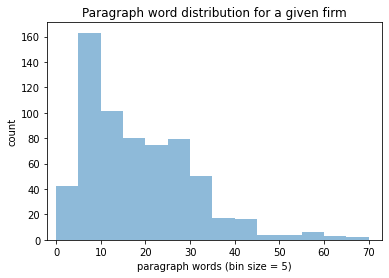

In [14]:
test_firm_texts = [i for i in all_docs_dict['Chevron USA.txt']]
lens = [len(t) for t in test_firm_texts]
pp.pprint (sorted(test_firm_texts, key=len))

bins = np.arange(0, 100, 5) # fixed bin size

plt.xlim([min(lens)-5, max(lens)+5])
plt.hist(lens, bins=bins, alpha=0.5)
plt.title('Paragraph word distribution for a given firm')
plt.xlabel('paragraph words (bin size = 5)')
plt.ylabel('count')

plt.show() # this exercise suggests removing all entries <6 words would make sense

In [15]:
SEGMENT_DIR = BASE_DATA_DIR + "orgs/segments/"

# standard firm cleaning regex
def clean_firm_name (firm):
    firm_clnd = re.sub('(\.|,| corporation| incorporated| llc| inc| international| gmbh| ltd)', '', firm, flags=re.IGNORECASE).rstrip()
    return firm_clnd

def pick_firms (firm_file, all_docs_dict):
    with open(SEGMENT_DIR + firm_file) as f:
        firms = f.readlines()
    clnd_file_names = list(map (lambda x: clean_firm_name(re.sub(r'\/', r'\|', x).rstrip('\r\n')) + '.txt', firms))
    segment_dict = {}
    for name in clnd_file_names:
        if name in all_docs_dict:
            segment_dict[name] = all_docs_dict[name]
        else: 
            pass 
            # print ("Cannot find " + name)
    return segment_dict

In [16]:
# create different training sets by industry
green_firms_file = "green_small_firms.csv"
synbio_firms_file = "synbio_small_firms.csv"
nano_firms_file = "nano_small_firms.csv"

green_docs_dict= pick_firms(green_firms_file, documents_dict)
green_docs = process_doc_list(green_docs_dict)

synbio_docs_dict= pick_firms(synbio_firms_file, documents_dict)
synbio_docs = process_doc_list(synbio_docs_dict)

nano_docs_dict= pick_firms(nano_firms_file, documents_dict)
nano_docs = process_doc_list(nano_docs_dict)

Working on 18 firm documents
Working on 13 firm documents
Working on 23 firm documents


## Get train/test set

In [17]:
def train_test_split (docs_dict):
    '''
    input: documents dictionary
    output: returns a list of train/test splits of the document dictionary 
    '''
    cos = list(docs_dict.keys())
    random.shuffle(cos) # shuffles in place
    
    cos_train = cos[:train_index]
    docs_dict_train = {key: docs_dict[key] for key in cos_train}
    
    cos_test = cos[train_index:]
    docs_dict_test = {key: docs_dict[key] for key in cos_test}
    
    return docs_dict_train, docs_dict_test

In [18]:
all_train, all_test = train_test_split(documents_dict)
synbio_train, synbio_test = train_test_split (synbio_docs_dict)
nano_train, nano_test = train_test_split (nano_docs_dict)
green_train, green_test = train_test_split (green_docs_dict)

NameError: name 'train_index' is not defined

## Run Topic Modelling

In [ ]:
def topic_model(train, test, topics):
    '''
    input: preprocessed test and training data, optionally the number of topics
    output: a fitted LDA topic model and the bow representation of test data for model evaluation
    '''
    random.seed(1)
    #create topic model on full text
    #will need to run on server when we have more data
    full_dict = corpora.Dictionary(train)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train]
    test_token = [full_dict.doc2bow(doc) for doc in test]
    lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=topics) 
    return lda, test_token

In [ ]:
k = [2, 5, 10, 15, 20, 25, 30, 40 , 50, 75, 100] # possible number of topics
def calculate_perplexities(train,test, k):
    '''
    inputs: preprocessed test and training data, a list of possible number of topics
    outputs: log perplexity and perplexity, scored on the test set
    '''
    log_perplexities = []
    perplexity = []
    for i in k:
        model, test_doc2bow = topic_model(train, test, i)
        log_p = model.log_perplexity(test_doc2bow)
        log_perplexities.append(log_p)
        perp = model.bound(test_doc2bow)
        perplexity.append(perp)
    return log_perplexities, perplexity

In [175]:
all_train

{'WiSys Technology Foundation.txt': ['Institutions',
  'Oshkosh',
  'UW-Eau Claire',
  'UW-Green Bay',
  'UW-La Crosse',
  'UW-Parkside',
  'UW-Platteville',
  'UW-River Falls',
  'UW-Stevens Point',
  'UW-Stout',
  'UW-Superior',
  'UW-Whitewater',
  'Colleges',
  'Extension',
  'Realize Your Idea',
  'Before Disclosing',
  'Invention Disclosure',
  'Disclosing your Invention',
  'Intellectual Property Protection',
  'Patents',
  'Other Types of Protection',
  'Commercialization',
  'Licensing',
  'Starting a Company',
  'Startups',
  'FAQs',
  'Take Ideas to Market',
  'Technologies',
  'Working with Industry Licensing Process',
  'Investing in or Creating a Startup',
  'FAQs',
  'News',
  'Success Stories',
  'News',
  'Events',
  'APPStart',
  'Quick Pitch',
  'Wisconsin Big Idea Tournament',
  'Timeline',
  'Eligibility & Judging',
  'At-Large Round',
  'Sponsors',
  'WSTS',
  'Grants',
  'Applied Research Grants',
  'Prototype Development Fund',
  'WiSCAP',
  'Spark Grant',
  'Pr

In [174]:
all_log_perplexities, all_perplexities = calculate_perplexities(all_train, all_test, k)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [29]:
green_log_perplexities, green_perplexities = calculate_perplexities(green_train, green_test, k)
synbio_log_perplexities, synbio_perplexities = calculate_perplexities(synbio_train, synbio_test, k)
nano_log_perplexities,nano_perplexities= calculate_perplexities(nano_train, nano_test, k)

### Perplexity Plots for each website type

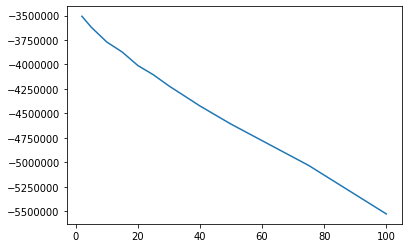

In [30]:
import matplotlib.pyplot as plt
plt.plot(k, all_perplexities)

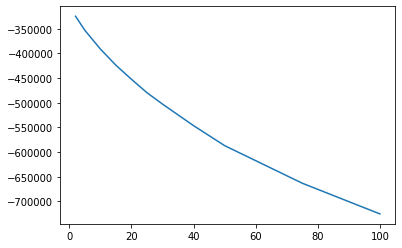

In [31]:
plt.plot(k, green_perplexities)

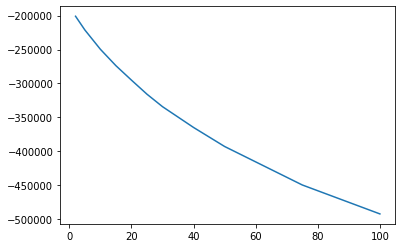

In [32]:
plt.plot(k, synbio_perplexities)

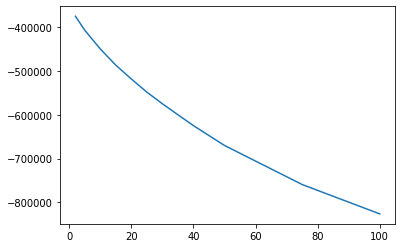

In [33]:
plt.plot(k, nano_perplexities)

### Compute coherence scores

In [144]:
# set k boundaries
limit=14; start=2; step=2

# Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (#17).
def compute_coherence_values(dictionary, corpus, texts,  start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(MALLET_PATH, corpus, id2word=dictionary, num_topics=num_topics, optimize_interval=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def visualize_coherence_values (train_test):
    full_dict = corpora.Dictionary(train_test)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train_test]
    
    # Can take a long time to run
    model_list, coherence_values = compute_coherence_values(dictionary=full_dict, corpus=DT_matrix, texts=train_test, start=start, limit=limit,step=step)
    
    # Show graph
    x = list(range(start, limit, step))
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

Working on dataset: nano


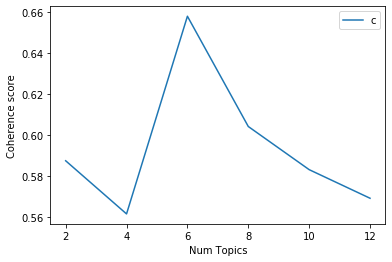

In [45]:
sector = 'nano'

datasets = { 'green': {'train_test': green_train_test,'docs': green_docs_dict},
            'nano': {'train_test': nano_train_test, 'docs': nano_docs_dict}, 
            'synbio': {'train_test': synbio_train_test, 'docs': synbio_docs_dict }}

for key, data in datasets.items():
    if key != sector:
        continue
    print ('Working on dataset: ' + key)
    visualize_coherence_values(data['train_test'])

### Predict topics by paragraph

In [46]:
# define data structs and train model
dataset = datasets[sector]['train_test']
k = 6

full_dict = corpora.Dictionary(dataset)
DT_matrix = [full_dict.doc2bow(doc) for doc in dataset]

lda_mallet = gensim.models.wrappers.LdaMallet(MALLET_PATH, corpus=DT_matrix, num_topics=k, id2word=full_dict, optimize_interval=10)

#### Visualize topics

In [47]:
lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet) # viz doesn't work with mallet
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, DT_matrix, full_dict)
pyLDAvis.display(LDAvis_prepared)

In [48]:
x=lda_mallet.show_topics(num_topics=k, num_words=20,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
#Below Code Prints Topics and Words
labels = []
for topic,words in topics_words:
    pp.pprint(str(topic)+ "::"+ str(words))
    labels.append('|'.join(words[0:5]))

("0::['univers', 'presid', 'serv', 'manag', 'director', 'board', 'mr.', "
 "'engin', 'develop', 'vice', 'offic', 'execut', 'year', 'dr.', 'join', "
 "'research', 'chief', 'scienc', 'prior', 'includ']")
("1::['develop', 'research', 'cancer', 'clinic', 'drug', 'diseas', 'medic', "
 "'treatment', 'patient', 'medicin', 'biolog', 'detect', 'test', 'diagnost', "
 "'cell', 'system', 'health', 'platform', 'therapi', 'therapeut']")
("2::['inform', 'ani', 'provid', 'person', 'data', 'pleas', 'servic', 'site', "
 "'includ', 'law', 'websit', 'tesla', 'contact', 'email', 'result', 'requir', "
 "'access', 'time', 'parti', 'collect']")
("3::['award', 'stori', 'amp', 'correct', 'state', 'error', '2018', 'salon', "
 "'regret', 'year', '2019', 'articl', 'confer', '2016', 'receiv', 'origin', "
 "'post', 'made', 'incorrect', 'american']")
("4::['custom', 'servic', 'manag', 'develop', 'provid', 'solut', 'innov', "
 "'work', 'cloud', 'industri', 'support', 'team', 'global', 'market', 'world', "
 "'experi', 

In [49]:
# print topic labels for import into R (note these need to be copied into R every time you train a new topic model)
print ("Copy this into R:")
labels_out = 'c("start|state","' + '", "'.join(labels) + '")'

print (labels_out)
labels_file = BASE_DATA_DIR + '/orgs/para_topics_panel/' + sector + '_labels.txt' # where output files are stored
if os.path.isfile(labels_file):
    os.remove(labels_file)
    
with open(labels_file, 'a') as lf:
    lf.write(labels_out)

Copy this into R:
c("start|state","univers|presid|serv|manag|director", "develop|research|cancer|clinic|drug", "inform|ani|provid|person|data", "award|stori|amp|correct|state", "custom|servic|manag|develop|provid", "system|develop|manufactur|materi|design")


#### Create output data structure and write to file

In [50]:
# test topic inference and top topic extract in lda mallet
para_topic_2 = 'power develop energy provide service market custom system'
para_topic_3 = 'manage universal director president board leadership phd doctor'

topic_by_prob = sorted([(i[1],i[0]) for i in lda_mallet[full_dict.doc2bow(utils.simple_preprocess(para_topic_3))]], reverse = True)
pp.pprint(topic_by_prob)

print(topic_by_prob[0][1])
print(topic_by_prob[0][0])

[(0.8796323743972226, 0),
 (0.033211540185033306, 2),
 (0.029996099721394047, 4),
 (0.02802927933820974, 1),
 (0.018690079304449974, 5),
 (0.010440627053690319, 3)]
0
0.8796323743972226


In [ ]:
topic_by_firm_vector = {} # at the firm level

# create output data structure
for firm_key in datasets[sector]['docs']: # or nano_docs or synbio_docs
    firm_paras = all_docs_dict[firm_key]
    print ('Working on ' + firm_key + ' with ' + str(len(firm_paras)) + ' paragraphs.')
    main_topic = [] # at the firm level, where each para is an entry
    main_topic_probs = [] # same, but for probabilities
    para_order = []
    para_len = [] 
    order_num = 0

    # start state
    main_topic.append(-1)
    main_topic_probs.append(1)
    para_order.append(order_num)
    order_num += 1
    para_len.append(0)
    
    for para in firm_paras:
        para_len.append(len(para))
        topic_by_prob = sorted([(i[1],i[0]) for i in lda_mallet[full_dict.doc2bow(para)]], reverse = True)
        main_topic.append(topic_by_prob[0][1])
        main_topic_probs.append(topic_by_prob[0][0])
        para_order.append(order_num)
        order_num += 1

    firm_df = pd.DataFrame(
        {'firm': re.sub('\|', '/', firm_key.split('.')[0]), 
         'para_order': para_order,
         'num_words': para_len,
         'main_topic': main_topic,
         'prob': main_topic_probs
        })
    topic_by_firm_vector[firm_key] = firm_df # set at the firm level 

Working on ACACIA RESEARCH GROUP.txt with 33 paragraphs.
Working on NanoOncology.txt with 49 paragraphs.
Working on Immunolight.txt with 64 paragraphs.
Working on Kinetech Power Company.txt with 13 paragraphs.
Working on Lux Bio Group.txt with 4 paragraphs.
Working on Magnolia Solar.txt with 80 paragraphs.
Working on Mattson Technology.txt with 74 paragraphs.
Working on The Paymaster.txt with 34 paragraphs.
Working on PortaFire.txt with 1 paragraphs.
Working on Soliton Lasers.txt with 26 paragraphs.
Working on S&S X-Ray Products.txt with 11 paragraphs.
Working on True-Safe Technologies.txt with 21 paragraphs.
Working on VERLASE TECHNOLOGIES.txt with 2 paragraphs.
Working on Crystal Solar.txt with 6 paragraphs.
Working on SII Semiconductor.txt with 74 paragraphs.
Working on Alliance for Sustainable Energy.txt with 5 paragraphs.
Working on Arkival Technology Corp.txt with 4 paragraphs.
Working on Coactive Drive.txt with 18 paragraphs.
Working on FRONT EDGE TECHNOLOGY.txt with 2 paragraph

In [ ]:
# Test output for a given firm 
print ('Found output for ' + str(len(topic_by_firm_vector.keys())) + ' firms.  Here is an example:')
pp = pprint.PrettyPrinter()
pp.pprint (documents_dict['US NUTRACEUTICALS.txt'])
pp.pprint (all_docs_dict['US NUTRACEUTICALS.txt'])
print(topic_by_firm_vector['US NUTRACEUTICALS.txt'])